# **Workshop -001: Extract**

**Importación de las librerias a utilizar**

In [1]:
import yaml
import psycopg2 
from psycopg2 import sql
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


**Creamos una función donde leemos el archivo de configuración de la DB y cargamos los datos de la conexión**

In [2]:
def load_config(file_path="config.yaml"):
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

**Llamamos a la funcion que carga los dados de conexión a la base de datos, y creamo la conexión**

In [3]:
config = load_config()
db_config = config["database"]

db_user = db_config["user"]
db_password = db_config["password"]
db_host = db_config["host"]
db_port = db_config["port"]
db_name = db_config["name"]

conn = psycopg2.connect(
    dbname="postgres",
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
conn.autocommit = True

**Creamos la base de datos en caso de que no exista**

In [4]:
db_name = "etl_db"
try:
    with conn.cursor() as cur:
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(db_name)))
        print(f"Base de datos '{db_name}' creada exitosamente.")
except psycopg2.errors.DuplicateDatabase:
    print(f"La base de datos '{db_name}' ya existe.")
finally:
    conn.close()

La base de datos 'etl_db' ya existe.


**Creamos las tablas necesarias a utilizar en el proyecto**

In [5]:
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

with engine.connect() as conn:
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS candidate_staging (
            id SERIAL PRIMARY KEY,
            first_name varchar(100),
            last_name varchar(100),
            email varchar(100),
            application_date date, 
            country varchar(100),                                           
            yoe int,
            seniority varchar(20),
            technology varchar(100),       
            code_challenges_core int,
            technical_interviews_core int,                            
            fecha_registro TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
    """))
    conn.commit() 
    print("Tabla: candidate_staging creada exitosamente en PostgreSQL.")

    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS candidate_transformed (
            id SERIAL PRIMARY KEY,
            first_name varchar(100),
            last_name varchar(100),
            email varchar(100),
            application_date date, 
            country varchar(100),                                           
            yoe int,
            seniority varchar(20),
            technology varchar(100),       
            code_challenges_core int,
            technical_interviews_core int, 
            is_hired boolean NOT NULL DEFAULT false,                      
            fecha_registro TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
    """))
    conn.commit() 
    print("Tabla: candidate_transformed creada exitosamente en PostgreSQL.")

Tabla: candidate_staging creada exitosamente en PostgreSQL.
Tabla: candidate_transformed creada exitosamente en PostgreSQL.


**Leemos los datos del archivo CSV, e imprimimos 15 registros**

In [6]:
df = pd.read_csv('candidates.csv', sep=';')

In [7]:
print(df.sample(n=15))

      First Name   Last Name                             Email  \
28045   Marshall       Boyle          antoinette55@hotmail.com   
28110        Ted       Grant            veda_lynch@hotmail.com   
35563    Jocelyn       Frami           rylan_mills25@gmail.com   
10967      Heber      Zemlak              hellen61@hotmail.com   
14646      Maida      Skiles       garfield_wunsch@hotmail.com   
33954      Kyler      Corwin           junius.turner@yahoo.com   
8967     Laverne   Bahringer                kayley33@yahoo.com   
34034     Alaina        Torp                  danny7@gmail.com   
12900   Salvador       Rohan            hazle_auer@hotmail.com   
34517     Leslie    Emmerich           sim_mcglynn@hotmail.com   
27978    Dariana  Hodkiewicz        julie_schaefer51@gmail.com   
16478       Avis  Wintheiser            haylie_orn15@yahoo.com   
30804    Octavia      Kohler          cristal.torp@hotmail.com   
6493      Ernest        Lowe               dasia41@hotmail.com   
29218     

**Copiamos los datos en una nueva variable, para guardarlos en la tabla candidate_staging**

In [8]:
df_staging = df.copy()

df_staging.sample(n=15)

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
11211,Shanon,Rodriguez,finn.dubuque@hotmail.com,2019-02-28,Saint Pierre and Miquelon,3,Architect,Sales,1,0
20426,Gerard,Walker,frank_leannon47@gmail.com,2018-03-21,Dominica,25,Senior,Security,4,8
34144,Lempi,Gislason,serenity.harber96@gmail.com,2020-09-30,Kazakhstan,7,Trainee,Social Media Community Management,9,9
27410,Emelia,Goodwin,laurie_hagenes88@yahoo.com,2019-07-27,Iraq,18,Intern,DevOps,8,8
49593,Julia,Wehner,miguel47@yahoo.com,2018-02-03,French Polynesia,8,Junior,Development - Frontend,3,3
4694,Annamae,Bogan,lue10@gmail.com,2021-07-20,Guadeloupe,11,Trainee,Technical Writing,6,1
46431,Tracy,Macejkovic,reinhold.blanda90@gmail.com,2018-09-03,Northern Mariana Islands,9,Mid-Level,Development - Frontend,0,3
7535,Braeden,Blanda,ward_oconner@hotmail.com,2020-08-21,Luxembourg,11,Lead,Sales,0,4
45416,Jaleel,Smith,fanny86@hotmail.com,2021-05-04,Latvia,2,Mid-Level,Game Development,9,1
35005,Velva,Ankunding,pearlie96@hotmail.com,2021-01-10,Lesotho,11,Junior,Salesforce,4,2


**Renombramos los nombres de las columnas para que coincidan con la estructura de la tabla de la DB**

In [9]:
print(df_staging.columns)

df_staging = df_staging.rename(columns={
    'First Name': 'first_name',
    'Last Name': 'last_name',
    'Email': 'email',
    'Application Date': 'application_date',
    'Country': 'country',
    'YOE': 'yoe',
    'Seniority': 'seniority',
    'Technology': 'technology',
    'Code Challenge Score': 'code_challenges_core',
    'Technical Interview Score': 'technical_interviews_core'
})

print(df_staging.columns)

Index(['First Name', 'Last Name', 'Email', 'Application Date', 'Country',
       'YOE', 'Seniority', 'Technology', 'Code Challenge Score',
       'Technical Interview Score'],
      dtype='object')
Index(['first_name', 'last_name', 'email', 'application_date', 'country',
       'yoe', 'seniority', 'technology', 'code_challenges_core',
       'technical_interviews_core'],
      dtype='object')


**Guardamos los datos cargados desde el CSV, a la tabla *candidate_staging* de la base de datos**

In [10]:
with engine.connect() as conn:
    df_staging.to_sql("candidate_staging", con=engine, if_exists="append", index=False)

print("Los datos cargados desde archivo CSV, se almacenaron correctamente en la tabla: candidate_staging")

Los datos cargados desde archivo CSV, se almacenaron correctamente en la tabla: candidate_staging


**Consultamos los datos de la tabla de *candidate_staging* para realizar el proceso de transformación**

In [11]:
with engine.connect() as conn:
    db_staging_df = pd.read_sql("SELECT * FROM candidate_staging", conn)
    
db_staging_df.sample(n=15)

,id,first_name,last_name,email,application_date,country,yoe,seniority,technology,code_challenges_core,technical_interviews_core,fecha_registro
38743,38744,Iliana,Hodkiewicz,gino.emard69@yahoo.com,2022-01-22,Cyprus,27,Mid-Level,Salesforce,10,8,2025-02-21 22:23:59.204438
17015,17016,Kenny,Herzog,torrey.kerluke55@hotmail.com,2018-12-10,Egypt,6,Mid-Level,Business Analytics / Project Management,4,1,2025-02-21 22:23:59.204438
28830,28831,Ellen,Schaden,beverly.kling@gmail.com,2022-05-20,Guatemala,20,Architect,Client Success,5,0,2025-02-21 22:23:59.204438
21936,21937,Michel,Kutch,maud_veum@yahoo.com,2019-12-04,United Kingdom,11,Architect,Database Administration,6,8,2025-02-21 22:23:59.204438
40528,40529,Devin,Rowe,peyton_hermann@gmail.com,2019-09-06,Venezuela,20,Lead,Design,4,4,2025-02-21 22:23:59.204438
38261,38262,Kaci,Kovacek,ally83@yahoo.com,2018-03-13,British Indian Ocean Territory (Chagos Archipe...,18,Intern,Security,8,4,2025-02-21 22:23:59.204438
6920,6921,Luther,Fay,carley_erdman@hotmail.com,2019-04-12,Kenya,13,Mid-Level,Design,10,1,2025-02-21 22:23:59.204438
46390,46389,Alaina,Metz,izabella3@hotmail.com,2020-09-16,Djibouti,25,Lead,Social Media Community Management,8,6,2025-02-21 22:23:59.204438
254,255,Ross,Lockman,myrtice18@gmail.com,2019-08-22,Tokelau,25,Lead,Development - FullStack,6,2,2025-02-21 22:23:59.204438
21783,21784,Donna,Spencer,martina31@hotmail.com,2020-06-01,Seychelles,9,Architect,Security Compliance,9,9,2025-02-21 22:23:59.204438


**Creamos una función, que permita evaluar las variables que determinan si un candidato en contratado o no**

In [12]:
# Definicion de fucion de validacion de la condicion de si es contratado o no
def response_IsHired(row):
    codeChallengeScore = row['code_challenges_core']
    technicalInterviewScore = row['technical_interviews_core']
    isHired = False
    
    if codeChallengeScore >= 7 and  technicalInterviewScore >= 7:
        isHired = True
    else:
        isHired = False
       
    return isHired


**Procesamos cada uno de los registro, y asignamos una nueva columna donde establecemos si el candidato en contratado o no**

In [13]:
df_transformed = db_staging_df.copy()
df_transformed["is_hired"] =  df_transformed.apply(response_IsHired, axis=1)


df_transformed.sample(n=15)

,id,first_name,last_name,email,application_date,country,yoe,seniority,technology,code_challenges_core,technical_interviews_core,fecha_registro,is_hired
32526,32523,Barton,Gislason,darron80@yahoo.com,2021-03-27,Niue,28,Mid-Level,Mulesoft,7,1,2025-02-21 22:23:59.204438,False
44308,44309,Deshaun,Bartoletti,karelle_gaylord77@yahoo.com,2018-08-14,Morocco,26,Intern,Data Engineer,6,8,2025-02-21 22:23:59.204438,False
31335,31336,Claire,Harvey,olaf59@yahoo.com,2022-04-09,Hong Kong,9,Lead,System Administration,0,4,2025-02-21 22:23:59.204438,False
38645,38646,Tom,Oberbrunner,eugenia_reichel@gmail.com,2021-03-04,Costa Rica,26,Lead,Data Engineer,10,0,2025-02-21 22:23:59.204438,False
17011,17012,Queen,Fritsch,alexane76@yahoo.com,2021-06-28,Barbados,1,Senior,Mulesoft,10,0,2025-02-21 22:23:59.204438,False
41054,41054,Roxanne,Halvorson,kamille.rogahn13@hotmail.com,2018-07-25,Cape Verde,3,Junior,Adobe Experience Manager,4,5,2025-02-21 22:23:59.204438,False
16132,16132,Penelope,Schuppe,rhianna7@yahoo.com,2018-02-24,Ghana,25,Trainee,Business Intelligence,5,5,2025-02-21 22:23:59.204438,False
16879,16880,Thad,Jacobi,emil_pacocha@hotmail.com,2020-09-15,Malaysia,9,Architect,Development - FullStack,7,2,2025-02-21 22:23:59.204438,False
24286,24287,Linwood,Schmeler,raina.olson@gmail.com,2020-04-22,Wallis and Futuna,25,Mid-Level,Design,10,6,2025-02-21 22:23:59.204438,False
19939,19940,Hayley,Swift,mike98@gmail.com,2018-09-18,Cocos (Keeling) Islands,1,Architect,Development - Backend,5,6,2025-02-21 22:23:59.204438,False


**Ahora guardamos los datos transformados en la nueval tabla: *candidate_transformed*** 

In [14]:
with engine.connect() as conn:
    df_transformed.to_sql("candidate_transformed", con=engine, if_exists="append", index=False)

print("Los datos transformados se almacenaron correctamente en la tabla: candidate_transformed")

Los datos transformados se almacenaron correctamente en la tabla: candidate_transformed


**Ahora mostraremos un resumen de la cantidad de cantidatos que fueron contratados y los que no**

In [15]:
with engine.connect() as conn:
    db_transformed_summary_df = pd.read_sql("SELECT is_hired, COUNT(*) as total FROM candidate_transformed GROUP BY is_hired", conn)
    
db_transformed_summary_df

,is_hired,total
0,False,43302
1,True,6698


**Agremos dos gráficas para presentar el resumen de los resultados**

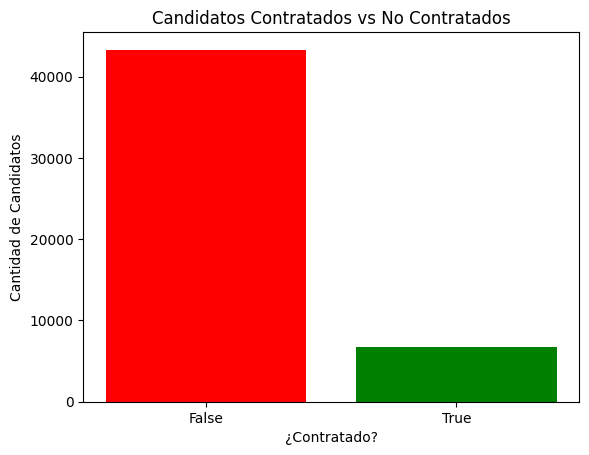

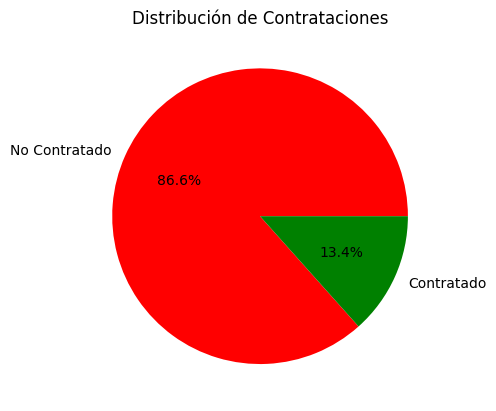

In [ ]:
# Configuración del gráfico de barras
plt.bar(db_transformed_summary_df['is_hired'].astype(str), db_transformed_summary_df['total'], color=['red', 'green'])
plt.xlabel('¿Contratado?')
plt.ylabel('Cantidad de Candidatos')
plt.title('Candidatos Contratados vs No Contratados')
plt.show()

# Configuración del gráfico de torta
plt.pie(db_transformed_summary_df['total'], labels=['No Contratado', 'Contratado'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Distribución de Contrataciones')
plt.show()